# Experimenting with different SpecletSeven parameterizations

## Setup

In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import logging
import re
import string
import warnings
from pathlib import Path
from time import time

import arviz as az
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import pymc3 as pm
import seaborn as sns
from theano import tensor as tt

In [7]:
from src.data_processing import achilles as achelp
from src.data_processing import common as dphelp
from src.exceptions import CacheDoesNotExistError
from src.globals import PYMC3
from src.io import cache_io
from src.loggers import logger, set_console_handler_level
from src.modeling import pymc3_analysis as pmanal
from src.modeling import pymc3_sampling_api as pmapi
from src.modeling import simulation_based_calibration_helpers as sbc
from src.models.speclet_seven import SpecletSeven, SpecletSevenConfiguration
from src.plot.color_pal import FitMethodColors, ModelColors, SeabornColor
from src.project_enums import MockDataSize, ModelFitMethod
from src.project_enums import ModelParameterization as MP

In [8]:
notebook_tic = time()

warnings.simplefilter(action="ignore", category=UserWarning)
set_console_handler_level(logging.WARNING)

gg.theme_set(
    gg.theme_bw()
    + gg.theme(
        figure_size=(4, 4),
        axis_ticks_major=gg.element_blank(),
        strip_background=gg.element_blank(),
    )
)
%config InlineBackend.figure_format = "retina"

RANDOM_SEED = 446
np.random.seed(RANDOM_SEED)

## Fitting models

In [9]:
# Centered parameterization.
config_cp = SpecletSevenConfiguration(h=MP.CENTERED, μ_h=MP.CENTERED)
sp7_cp = SpecletSeven("sp7-expt-cp", debug=True, config=config_cp)

# Non-centered parameterization.
config_ncp = SpecletSevenConfiguration(h=MP.CENTERED, μ_h=MP.NONCENTERED)
sp7_ncp = SpecletSeven("sp7-expt-ncp", debug=True, config=config_ncp)

for m in (sp7_cp, sp7_ncp):
    m._reset_model_and_results()
    m.cache_manager.clear_mcmc_cache()

[07/19/21 16:48:14] WARNING  Reseting all model and results.             ]8;id=1626727694.3290787-943239;file:///n/data1/hms/dbmi/park/Cook/speclet/src/models/speclet_model.py\speclet_model.py]8;;\:144

                    WARNING  Reseting all model and results.             ]8;id=1626727694.340963-967915;file:///n/data1/hms/dbmi/park/Cook/speclet/src/models/speclet_model.py\speclet_model.py]8;;\:144

In [10]:
def load_or_run_sbc(
    sp7: SpecletSeven, force: bool = False
) -> tuple[pd.DataFrame, sbc.SBCResults, sbc.SBCFileManager]:
    """Either load cached results of SBC or run a new round of SBC."""
    sbc_dir = sp7.cache_manager.cache_dir / "sbc"
    if not sbc_dir.exists():
        sbc_dir.mkdir()

    mock_data: pd.DataFrame
    sp7_sbc_res: sbc.SBCResults
    sp7_sbc_fm: sbc.SBCFileManager

    try:
        if force:
            raise CacheDoesNotExistError(Path("."))
        print("Trying to retrieve SBC data and results.")
        mock_data, sp7_sbc_res, sp7_sbc_fm = sp7.get_sbc(sbc_dir)
        print("Successfully retrieved SBC results from cache.")
    except CacheDoesNotExistError:
        print("Unable to retrieve SBC results from cache --> running SBC")
        sp7.run_simulation_based_calibration(
            results_path=sbc_dir,
            fit_method=ModelFitMethod.MCMC,
            random_seed=RANDOM_SEED,
            size=MockDataSize.MEDIUM,
            fit_kwargs={
                "draws": 1000,
                "tune": 1000,
                "chains": 2,
                "cores": 2,
                "prior_pred_samples": 1000,
                "target_accept": 0.95,
            },
        )
        mock_data = sp7.data_manager.get_data()
        sp7_sbc_fm = sbc.SBCFileManager(sbc_dir)
        sp7_sbc_res = sp7_sbc_fm.get_sbc_results()
    except Exception as err:
        print("Unexpected error.")
        print(err)

    return mock_data, sp7_sbc_res, sp7_sbc_fm

In [11]:
cp_mock_data, cp_sbc_res, cp_sbc_fm = load_or_run_sbc(sp7_cp, force=True)

Unable to retrieve SBC results from cache --> running SBC


[07/19/21 16:48:15] WARNING  Dropping 0 sgRNA that map to multiple ]8;id=1626727695.1963615-533195;file:///n/data1/hms/dbmi/park/Cook/speclet/src/managers/model_data_managers.py\model_data_managers.py]8;;\:250
                             genes.

                    WARNING  Dropping 0 data points with missing   ]8;id=1626727695.2030642-446330;file:///n/data1/hms/dbmi/park/Cook/speclet/src/managers/model_data_managers.py\model_data_managers.py]8;;\:260
                             copy number.

[07/19/21 16:49:27] WARNING  Dropping 0 sgRNA that map to multiple ]8;id=1626727767.3739567-948542;file:///n/data1/hms/dbmi/park/Cook/speclet/src/managers/model_data_managers.py\model_data_managers.py]8;;\:250
                             genes.

                    WARNING  Dropping 0 data points with missing   ]8;id=1626727767.3826838-741337;file:///n/data1/hms/dbmi/park/Cook/speclet/src/managers/model_data_managers.py\model_data_managers.py]8;;\:260
                             copy number.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, a, σ_a, σ_σ_a, h, σ_h, σ_σ_h, μ_h, σ_μ_h, μ_μ_h]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 938 seconds.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8508039181790841, but should be close to 0.95. Try to increase the number of tuning steps.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8706400768174166, but should be close to 0.95. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


In [12]:
ncp_mock_data, ncp_sbc_res, ncp_sbc_fm = load_or_run_sbc(sp7_ncp, force=True)

Unable to retrieve SBC results from cache --> running SBC


[07/19/21 17:06:21] WARNING  Dropping 0 sgRNA that map to multiple ]8;id=1626728781.9859595-848799;file:///n/data1/hms/dbmi/park/Cook/speclet/src/managers/model_data_managers.py\model_data_managers.py]8;;\:250
                             genes.

                    WARNING  Dropping 0 data points with missing   ]8;id=1626728781.9924362-862079;file:///n/data1/hms/dbmi/park/Cook/speclet/src/managers/model_data_managers.py\model_data_managers.py]8;;\:260
                             copy number.

[07/19/21 17:06:23] WARNING  Dropping 0 sgRNA that map to multiple ]8;id=1626728783.5301585-395729;file:///n/data1/hms/dbmi/park/Cook/speclet/src/managers/model_data_managers.py\model_data_managers.py]8;;\:250
                             genes.

                    WARNING  Dropping 0 data points with missing   ]8;id=1626728783.536644-301986;file:///n/data1/hms/dbmi/park/Cook/speclet/src/managers/model_data_managers.py\model_data_managers.py]8;;\:260
                             copy number.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, a, σ_a, σ_σ_a, h, σ_h, σ_σ_h, μ_h_offset, σ_μ_h, μ_μ_h]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 739 seconds.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8831367014014199, but should be close to 0.95. Try to increase the number of tuning steps.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9059971122600508, but should be close to 0.95. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


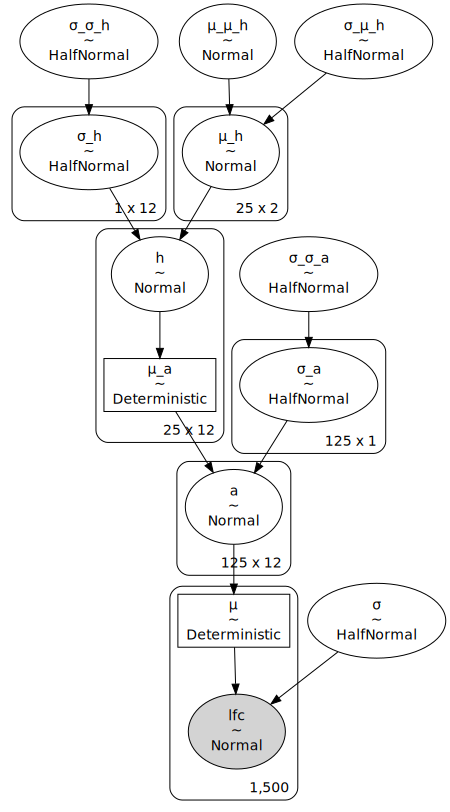

In [13]:
pm.model_to_graphviz(sp7_cp.model)

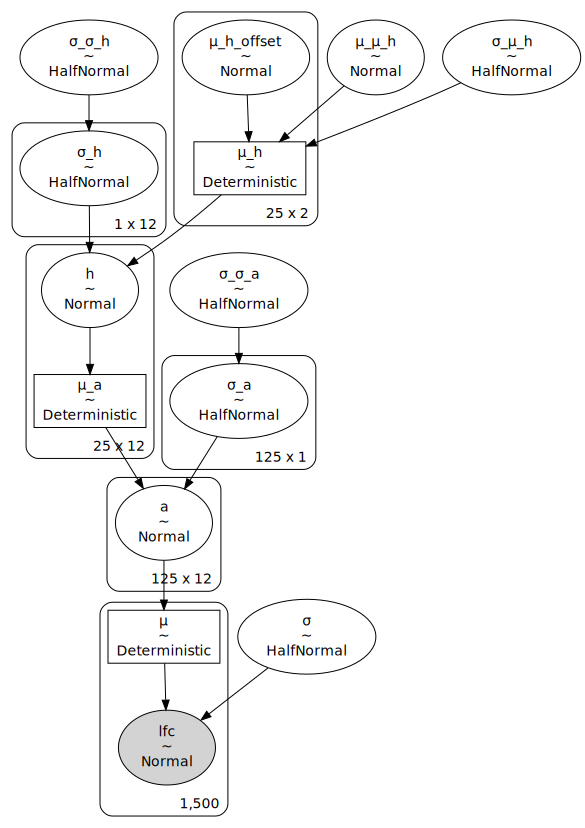

In [14]:
pm.model_to_graphviz(sp7_ncp.model)

## Analysis

*Note: To do true model comparison, the models would need to be fit with the same data.*

centered


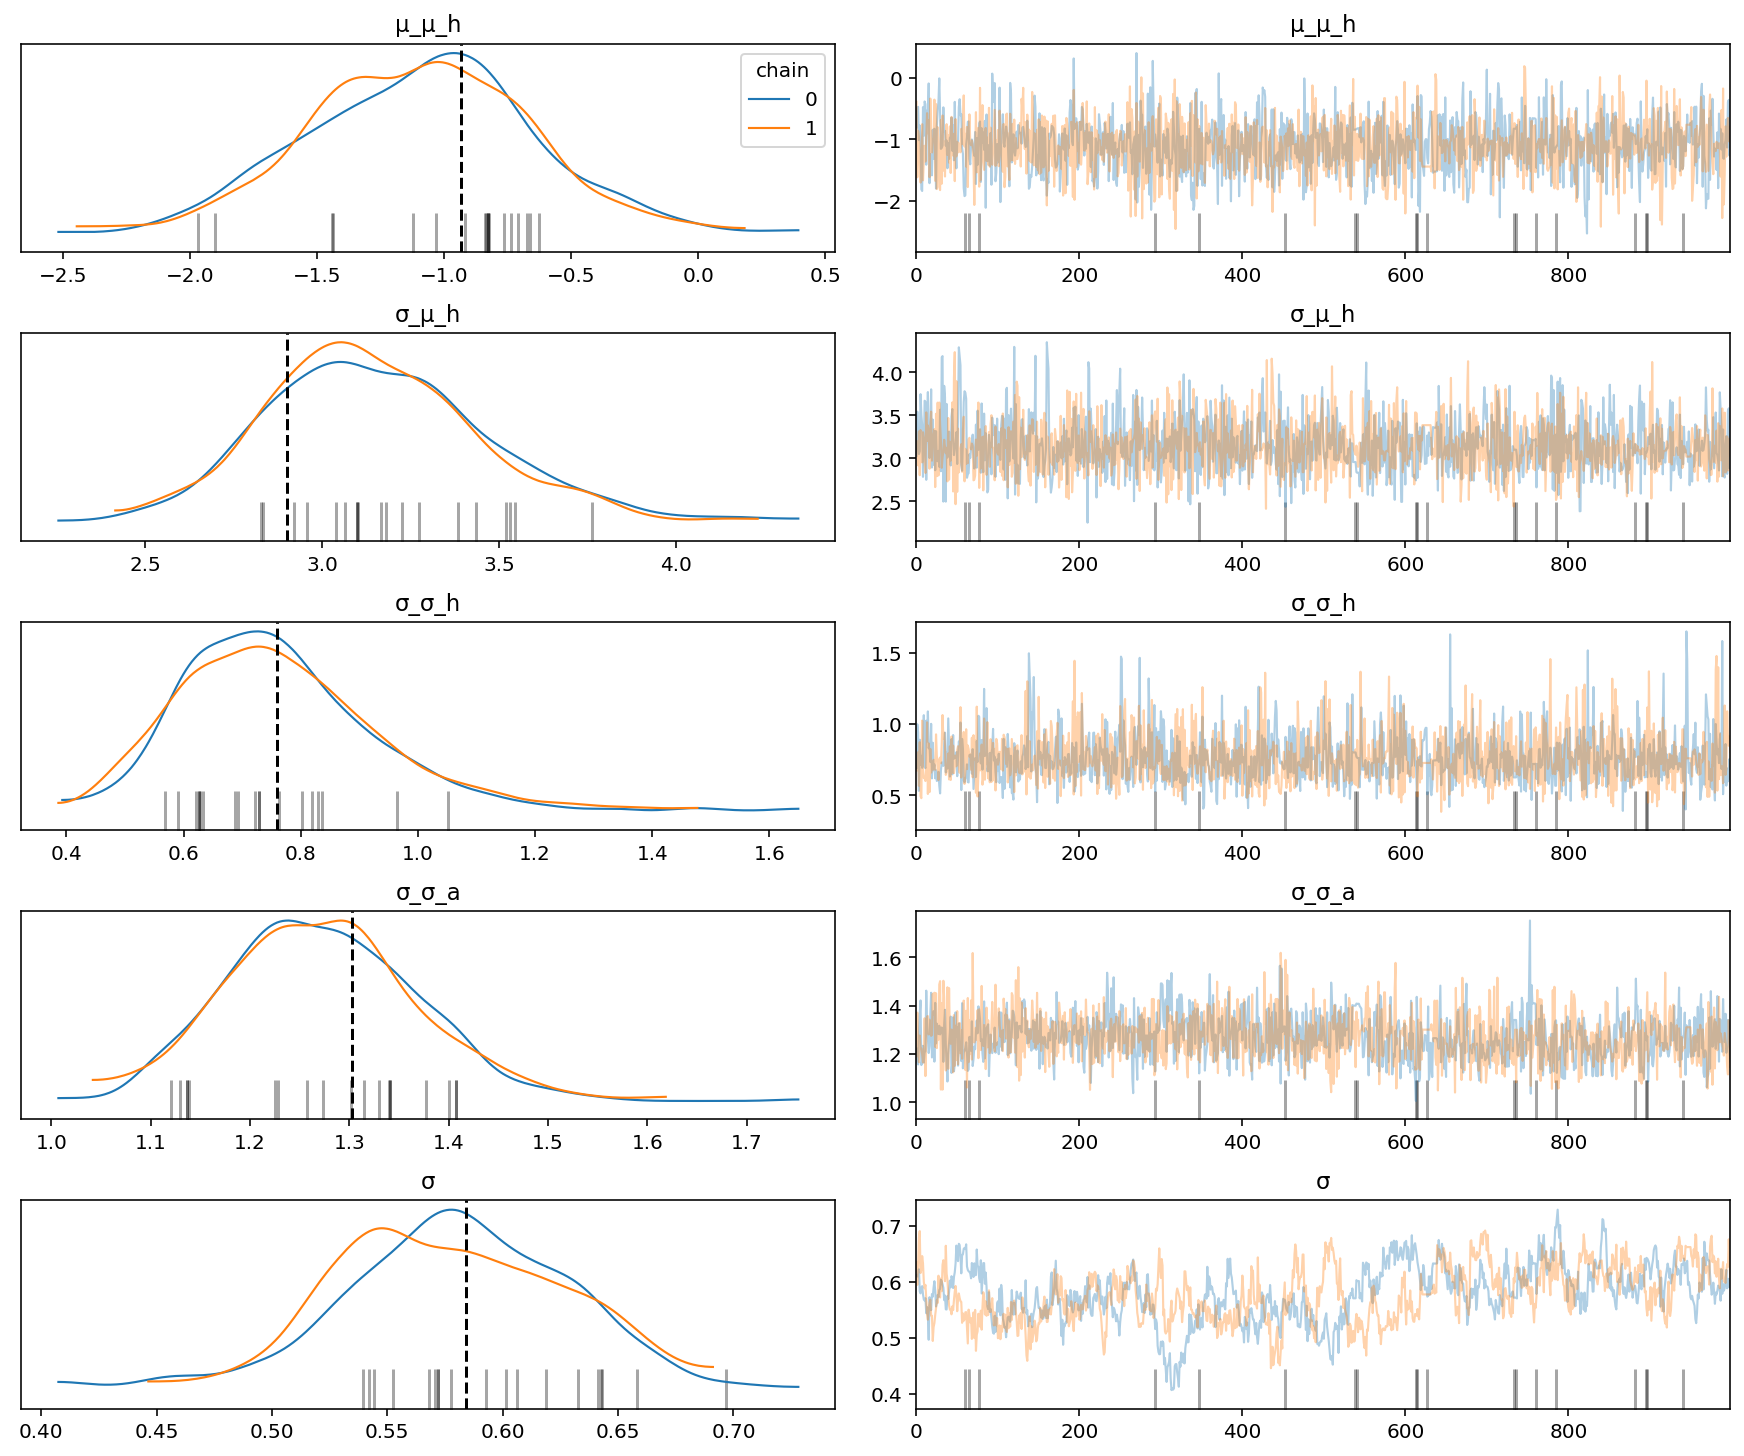

non-centered


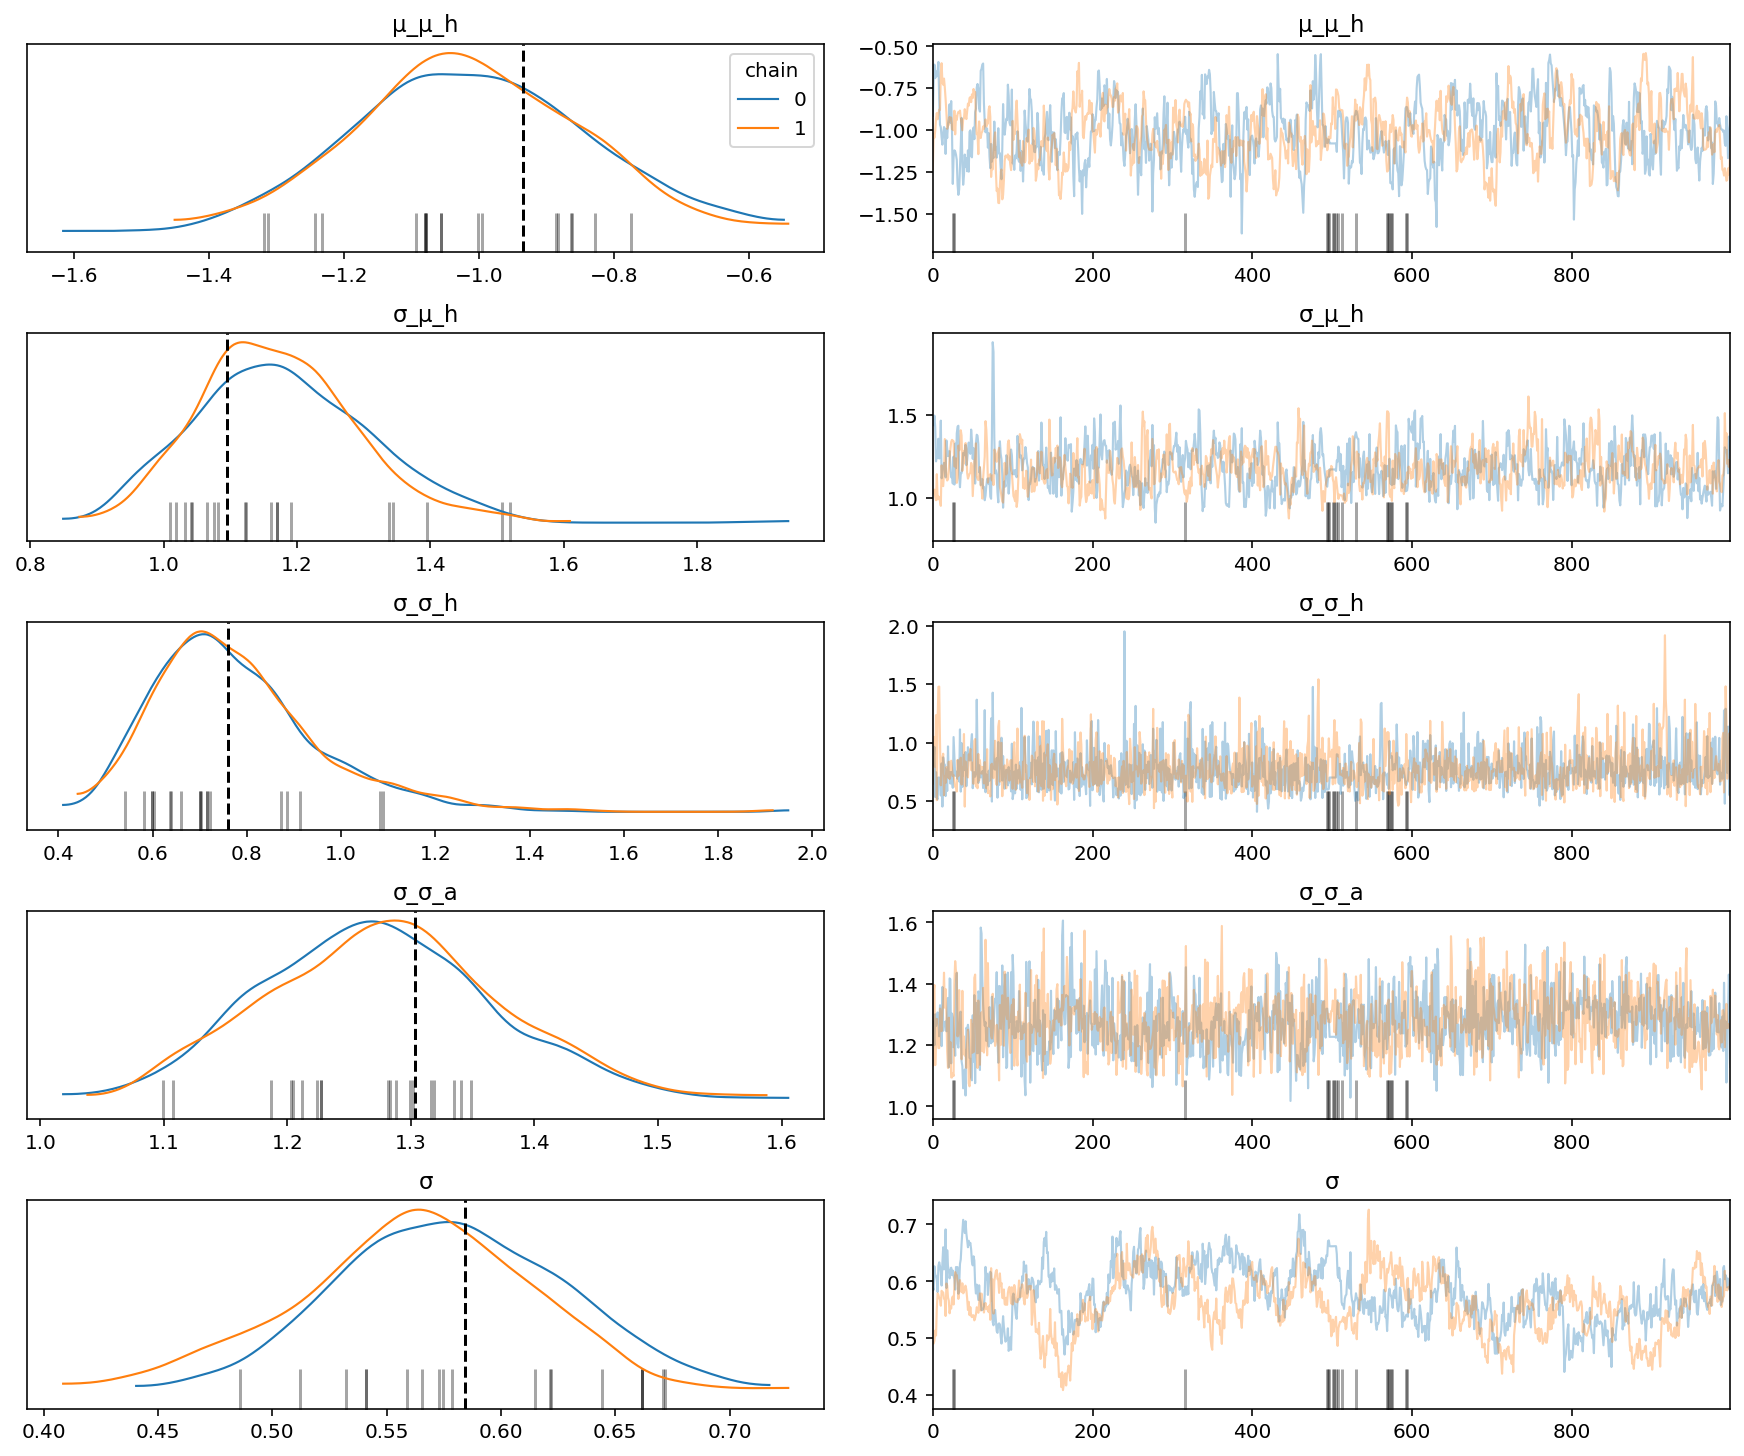

In [23]:
for model, res in zip(["centered", "non-centered"], [cp_sbc_res, ncp_sbc_res]):
    print(model)
    var_names = ["μ_μ_h", "σ_μ_h", "σ_σ_h", "σ_σ_a", "σ"]
    axes = az.plot_trace(
        res.inference_obj, var_names=var_names, compact=False, legend=True
    )
    known_values = [res.priors[p] for p in var_names]
    for ax, known_val in zip(axes[:, 0], known_values):
        ax.axvline(x=known_val, color="k", linestyle="--")
    plt.show()

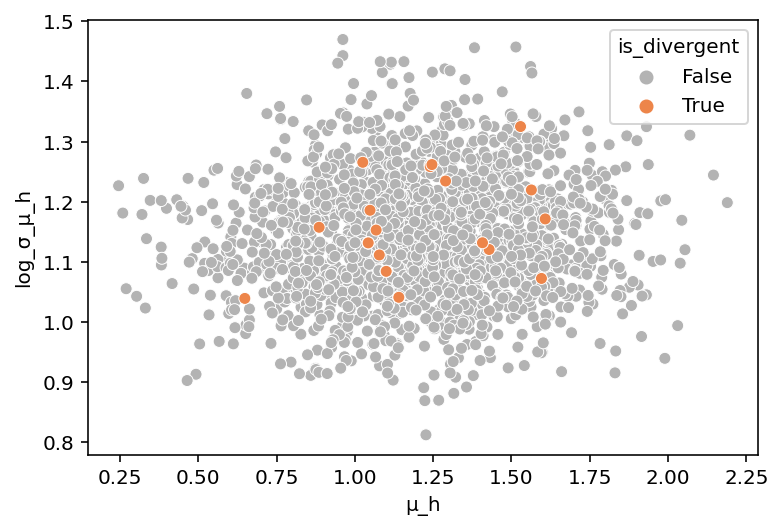

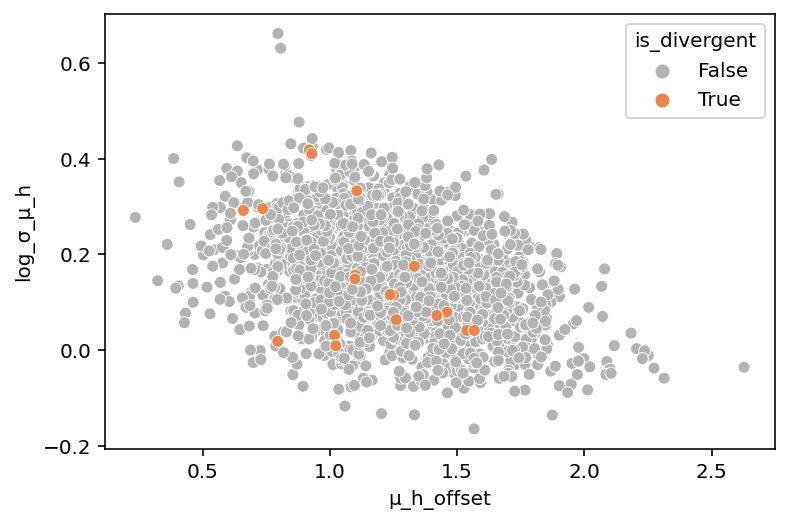

In [48]:
for model, res in zip(["centered", "non-centered"], [cp_sbc_res, ncp_sbc_res]):
    centrality_parm = "μ_h" if model == "centered" else "μ_h_offset"
    ncp_divs = pmanal.get_divergences(res.inference_obj)
    sigma_mu_h_draws = res.inference_obj.posterior["σ_μ_h"].values
    mu_h_draws = res.inference_obj.posterior[centrality_parm].values

    df = (
        pd.DataFrame(
            {
                "is_divergent": ncp_divs.flatten(),
                "σ_μ_h": sigma_mu_h_draws.flatten(),
                centrality_parm: mu_h_draws[:, :, 0, 0].flatten(),
            }
        )
        .assign(log_σ_μ_h=lambda d: np.log(d.σ_μ_h))
        .sort_values("is_divergent")
    )

    sns.scatterplot(
        data=df,
        x=centrality_parm,
        y="log_σ_μ_h",
        hue="is_divergent",
        palette={True: SeabornColor.ORANGE.value, False: "0.7"},
    )
    plt.show()

---

In [18]:
notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

execution time: 31.73 minutes


In [19]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2021-07-19

Python implementation: CPython
Python version       : 3.9.2
IPython version      : 7.21.0

Compiler    : GCC 9.3.0
OS          : Linux
Release     : 3.10.0-1062.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 28
Architecture: 64bit

Hostname: compute-e-16-233.o2.rc.hms.harvard.edu

Git branch: sp7-parameterizations

re        : 2.2.1
matplotlib: 3.3.4
theano    : 1.0.5
logging   : 0.5.1.2
pandas    : 1.2.3
pymc3     : 3.11.1
plotnine  : 0.7.1
numpy     : 1.20.1
seaborn   : 0.11.1
arviz     : 0.11.2

